# Spatio-temporal tradeoff v2

Replicating the results from Mohler et al in *The Concentration-Dynamics Tradeoff in Crime Hot Spotting*

In [17]:
%load_ext autoreload
%autoreload 2

In [18]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

from spatial import get_force_boundary, map_to_spatial_unit
from utils import Month, extract_crime_data

In [28]:
FORCE = "West Yorkshire"
filter = {"Crime type": "Anti-social behaviour"}
grid_size = 200
boundary = get_force_boundary(FORCE)
raw_crime_data = extract_crime_data(FORCE, filters=filter)

In [33]:
crime_data, features = map_to_spatial_unit(raw_crime_data, boundary, "GRID", size=grid_size)
# remove any outside force boundary
crime_data = crime_data[~crime_data.spatial_unit.isna()]
crime_data

,spatial_unit,BNG_E,BNG_N,LAT,LONG,Month,Reported by,Falls within,Location,LSOA code,LSOA name,Crime type,geometry
Crime ID,,,,,,,,,,,,,
NaN,28724.0,411300.0,447100.0,53.919920,-1.829433,2022-05,West Yorkshire Police,West Yorkshire Police,On or near Queen'S Gardens,E01010692,Bradford 001D,Anti-social behaviour,POINT (411354.013 447133.948)
NaN,29477.0,411900.0,447700.0,53.925299,-1.820274,2022-05,West Yorkshire Police,West Yorkshire Police,On or near Bus/Coach Station,E01010692,Bradford 001D,Anti-social behaviour,POINT (411854.969 447613.948)
NaN,29225.0,411700.0,447300.0,53.921709,-1.823335,2022-05,West Yorkshire Police,West Yorkshire Police,On or near Wells Road,E01010692,Bradford 001D,Anti-social behaviour,POINT (411758.03 447302.948)
NaN,29477.0,411900.0,447700.0,53.925299,-1.820274,2022-05,West Yorkshire Police,West Yorkshire Police,On or near Bus/Coach Station,E01010692,Bradford 001D,Anti-social behaviour,POINT (411854.969 447613.948)
NaN,29976.0,412300.0,447500.0,53.923493,-1.814191,2022-05,West Yorkshire Police,West Yorkshire Police,On or near Springs Lane,E01010691,Bradford 002A,Anti-social behaviour,POINT (412391.978 447481.039)
...,...,...,...,...,...,...,...,...,...,...,...,...,...
NaN,72793.0,446700.0,410900.0,53.592605,-1.295921,2025-04,West Yorkshire Police,West Yorkshire Police,On or near John Street,E01011863,Wakefield 044D,Anti-social behaviour,POINT (446750.007 410878.044)
NaN,72541.0,446500.0,410500.0,53.589027,-1.299002,2025-04,West Yorkshire Police,West Yorkshire Police,On or near Beech Street,E01011863,Wakefield 044D,Anti-social behaviour,POINT (446414.024 410431.008)
NaN,72793.0,446700.0,410900.0,53.592605,-1.295921,2025-04,West Yorkshire Police,West Yorkshire Police,On or near Princess Avenue,E01011863,Wakefield 044D,Anti-social behaviour,POINT (446666.975 410800.005)


In [34]:
windows = [1,2,3,4,5,6,9,12]

agg_data = crime_data.groupby(["Month", "spatial_unit"])["Crime type"].count().unstack(level="Month", fill_value=0).reindex(features.index, fill_value=0)
assert len(agg_data) == len(features)

windowed = pd.concat([agg_data.T.rolling(w).sum().T.mean(axis=1).rename(w) for w in windows], axis=1)
windowed #.iloc[:, :8].plot(title="Mean windowed crime count")

,1,2,3,4,5,6,9,12
361,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
362,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
363,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
364,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
365,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...
80600,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
80601,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
80602,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
80603,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [35]:
land_area = pd.DataFrame(index=windowed.columns, columns=["25% of crime", "50% of crime"])

for name, series in windowed.items():
    cumulative = series.sort_values().cumsum() / series.sum()
    land_area.loc[name, "25% of crime"] = 100 * len(cumulative[cumulative >= 0.75]) / len(cumulative)
    land_area.loc[name, "50% of crime"] = 100 * len(cumulative[cumulative >= 0.5]) / len(cumulative)
land_area

,25% of crime,50% of crime
1,0.657397,2.466694
2,0.64964,2.443423
3,0.641883,2.418213
4,0.636066,2.398821
5,0.632187,2.387186
6,0.628309,2.377489
9,0.622491,2.360036
12,0.614734,2.338705


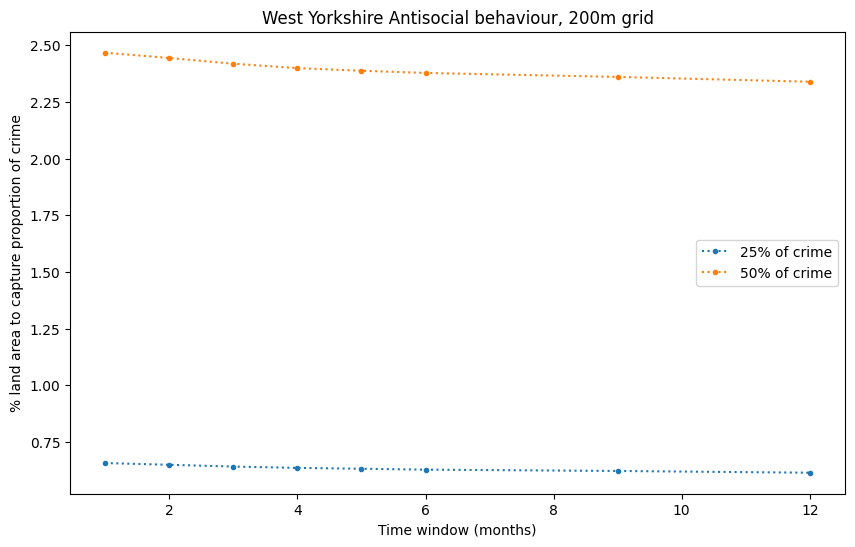

In [36]:
land_area.plot(
    marker=".",
    ls=":",
    ylabel="% land area to capture proportion of crime",
    xlabel="Time window (months)",
    title=f"West Yorkshire Antisocial behaviour, {grid_size}m grid",
    figsize=(10, 6),
);

In [37]:
overlap = pd.DataFrame(index=windowed.columns, columns=["25% of crime", "50% of crime"])

cumulative = windowed.iloc[:,0].sort_values().cumsum() / windowed.iloc[:,0].sum()
prev_locations25 = cumulative[cumulative >= 0.75].index
prev_locations50 = cumulative[cumulative >= 0.5].index

for name, series in windowed.items():
    if name == 1:
        continue
    cumulative = series.sort_values().cumsum() / series.sum()

    locations25 = cumulative[cumulative >= 0.75].index
    locations50 = cumulative[cumulative >= 0.5].index

    overlap25 = (
        100 * len(np.intersect1d(locations25, prev_locations25)) / len(np.union1d(locations25, prev_locations25))
    )
    overlap50 = (
        100 * len(np.intersect1d(locations50, prev_locations50)) / len(np.union1d(locations50, prev_locations50))
    )

    overlap.loc[name, "25% of crime"] = overlap25
    overlap.loc[name, "50% of crime"] = overlap50

    prev_locations25 = locations25
    prev_locations50 = locations50
overlap

,25% of crime,50% of crime
1,NaN,NaN
2,95.930233,97.349961
3,97.04142,95.249221
4,97.897898,98.086124
5,98.181818,97.598078
6,97.568389,97.191011
9,93.693694,95.44
12,95.705521,95.403226


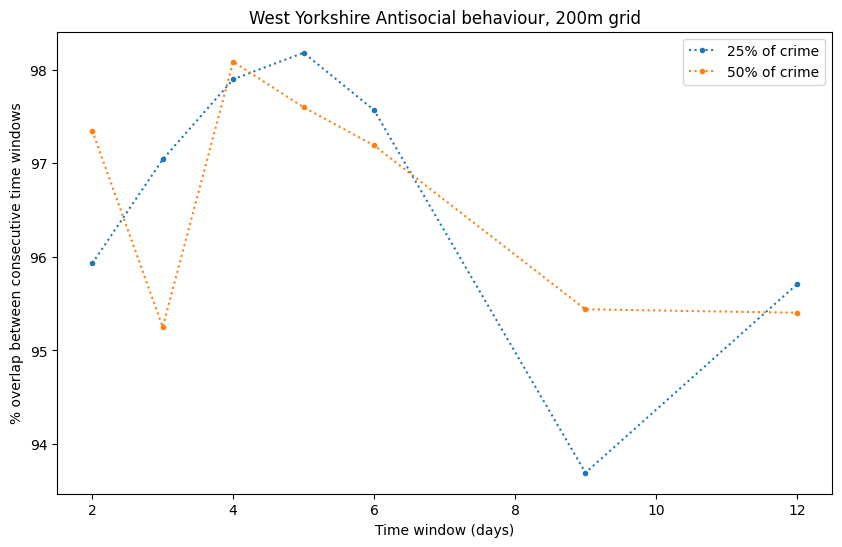

In [38]:
overlap.plot(
    marker=".",
    ls=":",
    ylabel="% overlap between consecutive time windows",
    xlabel="Time window (days)",
    title=f"West Yorkshire Antisocial behaviour, {grid_size}m grid",
    figsize=(10, 6),
);

In [39]:
both = land_area.join(overlap, lsuffix="_land_area").reset_index(names="days")
both #= both.head(len(both) - 2)

,days,25% of crime_land_area,50% of crime_land_area,25% of crime,50% of crime
0,1,0.657397,2.466694,NaN,NaN
1,2,0.64964,2.443423,95.930233,97.349961
2,3,0.641883,2.418213,97.04142,95.249221
3,4,0.636066,2.398821,97.897898,98.086124
4,5,0.632187,2.387186,98.181818,97.598078
5,6,0.628309,2.377489,97.568389,97.191011
6,9,0.622491,2.360036,93.693694,95.44
7,12,0.614734,2.338705,95.705521,95.403226


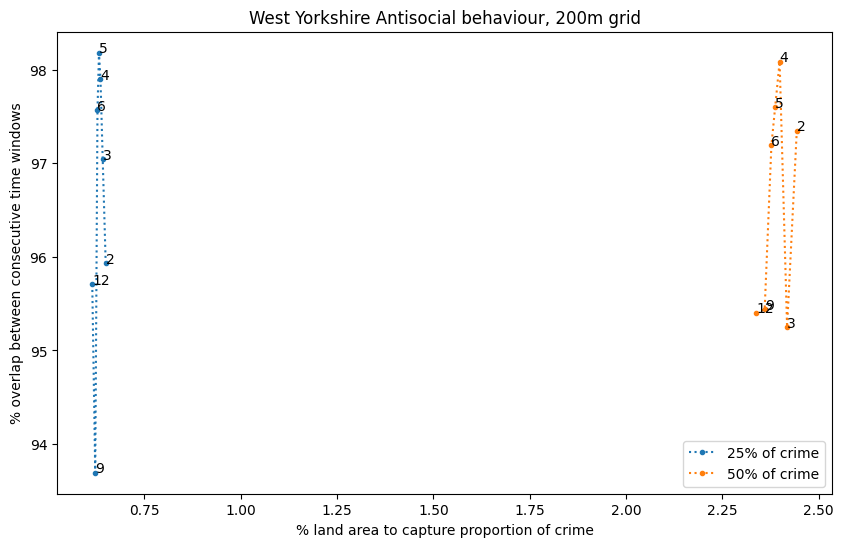

In [12]:
_, ax = plt.subplots(figsize=(10, 6))
ax.plot(both["25% of crime_land_area"], both["25% of crime"], label="25% of crime", ls=":", marker=".")
ax.plot(both["50% of crime_land_area"], both["50% of crime"], label="50% of crime", ls=":", marker=".")
ax.set_xlabel("% land area to capture proportion of crime")
ax.set_ylabel("% overlap between consecutive time windows")
ax.legend()

ax.set_title(f"West Yorkshire Antisocial behaviour, {grid_size}m grid")


for x, y, text in zip(both["25% of crime_land_area"], both["25% of crime"], both.days):
    plt.text(x, y, text)
for x, y, text in zip(both["50% of crime_land_area"], both["50% of crime"], both.days):
    plt.text(x, y, text)